In [714]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
from scipy.signal import find_peaks
from scipy.stats import bayes_mvs as bayesest
import os #Lib for get the operative system sintaxis
from sklearn import linear_model#Machine learning package for a smart plot fit
from scipy import stats
from decimal import Decimal
import math

In [2]:
#timebetframes=18#time between frames (min)
medium='m2'#medium
#thresh=30# minimum pixelsize for considering a peak in the signal
pixelsize=0.11 #pixelsize (mum/px)
fitthresh=0.8 #threshold in the fit score to consider the cell cicle

In [186]:
data=pd.read_csv("./rawdata.csv")

In [189]:
##Peak detection algorithm

def indexes(y):#peak detection algorithm
    dy = np.diff(y)
    #plt.plot(ady)
    ind = []
    for i in range(len(dy)-1):
        if len(ind) > 0:
            if abs(dy[i-1])<0.25*y[i] and dy[i]<-0.3*y[i] and abs(dy[i+1])<0.25*y[i]:
                ind.append(i)
        elif len(ind) == 0:
            if  dy[i]<-0.3*y[i]:
                ind.append(i)
    return ind  

In [191]:
%matplotlib inline
replica=data['Replica'].unique()

if not os.path.exists('./mmdatafull/'):
    os.makedirs('./mmdatafull/')   
if not os.path.exists('./mmdatafull/perfect'):
    os.makedirs('./mmdatafull/perfect')
if not os.path.exists('./mmdatafull/perfect'):
    os.makedirs('./mmdatafull/perfect') 
    
plt.rcParams.update({'figure.max_open_warning': 0})
#data=dataraw[dataraw.lane_num==lane]

DSMdata=[]#np.array([["Sb","Sd","gr","timediv","score","Replica"]])
CRMdata=[]#np.array([["Mother","time","SizeFit","Size","gr","score","Replica"]]) 
#td=[]
#goodsz=[]
#grsimple=[]
#gooddata=[]
filtdata=[]
repinx=1
for rep in replica:
    df=data[data.Replica==rep]
    moms=df['mom'].unique()
    grs=[]
    df=df.reset_index()
    tbf=(df.loc[1].time-df.loc[0].time)/60
    for k in range(len(moms)):
        tempCRM=[]
        tempv=[]
        dataM=df[df.mom==moms[k]]
        datat=dataM.sort_values(by="time")
        ln = np.array(datat.length)
        
        time = np.array(datat.time/60)
        
        peaksval=[]  
        fitl=[]
        fitt=[]
        peaks = indexes(ln)
        avscore=[]
        if (len(peaks)!=0):
            coor=[]
            for i in range(len(peaks)):        
                if(i>0):
                    d=float(time[peaks[i]]-time[peaks[i-1]])#division time
                    tt=peaks[i-1]+1#initial time for ransac estimation
                else:
                    d=0
                    tt=0
                peaksval.append([time[peaks[i]],ln[peaks[i]]]) 
                dt=[]#array of log(len)
                tm=[]
                results=[]
                temp=0
                while(tt<=peaks[i]):
                    dt.append(np.log(ln[tt]))
                    tm.append(temp)
                    temp=temp+tbf
                    tt=tt+1
                if(len(dt)>1):#guarantees there is enought data
                    tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
                    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
                    model_ransac.fit(tm,dt)#smart fit
                    a=model_ransac.estimator_.coef_#growth rate
                    l0=np.exp(model_ransac.estimator_.intercept_)
                    avscore.append(model_ransac.score(tm, dt))
                    if(i>0):
                        tt=peaks[i-1]+1#temporaltime
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[peaks[i-1]+1]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1
                        if(score>0.8):                        
                            tempvf=l0*np.exp((-time[peaks[i-1]+1]+time[peaks[i]]+(tbf/2))*a[0])
                            tempv0=l0*np.exp(-tbf*a[0]/2)
                            if tempvf>tempv0:                            
                                avt=(time[peaks[i-1]]+time[peaks[i]])/2
                                timediv=-time[peaks[i-1]]+time[peaks[i]]
                                tempv.append([tempv0,tempvf,tempvf-tempv0,a[0],avt,score,repinx])
                                tt=peaks[i-1]+1#temporaltime
                                if(model_ransac.score(tm,dt)>fitthresh):
                                    coor.append([time[peaks[i]]/60,pixelsize*ln[peaks[i]],model_ransac.score(tm,dt)])                         
                    else:
                        tt=0
                        score=model_ransac.score(tm,dt)
                        while(tt<=peaks[i]):
                            tempCRM.append([moms[k],time[tt],l0*np.exp((-time[0]+time[tt])*a[0]),ln[tt],a[0],score,repinx]) 
                            tt=tt+1 
            peaksval=np.array(peaksval)
        if len(tempv)>3:
            fitl=[]
            fitt=[]
            for gg in tempCRM:     
                if len(CRMdata)==0:
                    CRMdata=[gg]
                else:
                    CRMdata=np.concatenate((CRMdata,[gg]),axis=0)
                fitl.append(gg[2])
                fitt.append(gg[1])
            for pp in tempv:
                if len(DSMdata)==0:
                    DSMdata=[pp]
                else:
                    DSMdata=np.concatenate((DSMdata,[pp]),axis=0)
                    
                        
            #fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
        
            #ax.plot(np.array(fitt),pixelsize*np.array(fitl),c = 'g')
            #ax.scatter(np.array(time),pixelsize*np.array(ln),c = 'g',s = 20)
    repinx+=1
#            ax.scatter(np.array(peaksval[:,0])/60,pixelsize*np.array(peaksval[:,1]), c='r', s=50 )   
#            ax.set_ylim([0,10])
#            plt.xlabel('Time (hr)',fontsize=20)
#            plt.ylabel('Cellsize ($\mu$ m)',fontsize=20)
#            plt.tick_params(axis='x', labelsize=20)
#            plt.tick_params(axis='y', labelsize=20)
#            for bb in range(len(coor)):
#                plt.text(coor[bb][0],0.1+coor[bb][1],'Sc='+str("{0:.3f}".format(coor[bb][2])), style='italic',fontsize=15)
#            plt.savefig('D:/mmdata/'+str(medium)+'/'+str(lane)+'/perfect/mother'+str(k)+'.png',bbox_inches='tight')
#        else:
#            fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
#            ax.plot(np.array(fitt)/60,pixelsize*np.array(fitl),c = 'g')
#            ax.scatter(np.array(time)/60,pixelsize*np.array(ln),c = 'g',s = 20)
#            ax.scatter(np.array(peaksval[:,0])/60,pixelsize*np.array(peaksval[:,1]), c='r', s=50 )   
#            ax.set_ylim([0,10])
#            plt.xlabel('Time (hr)',fontsize=20)
#            plt.ylabel('Cellsize ($\mu$ m)',fontsize=20)
#            plt.tick_params(axis='x', labelsize=20)
#            plt.tick_params(axis='y', labelsize=20)
#            plt.savefig('D:/mmdata/'+str(medium)+'/'+str(lane)+'/mother'+str(k)+'.png',bbox_inches='tight')
#    else:
#        fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
#        ax.scatter(np.array(time)/60,pixelsize*np.array(ln),c = 'g',s = 20)
#        ax.set_ylim([0,10])
#        plt.xlabel('Time (hr)',fontsize=20)
#        plt.ylabel('Cellsize ($\mu$ m)',fontsize=20)
#        plt.tick_params(axis='x', labelsize=20)
#        plt.tick_params(axis='y', labelsize=20)
#        plt.savefig('D:/mmdata/'+str(medium)+'/'+str(lane)+'/mother'+str(k)+'.png',bbox_inches='tight')

In [718]:
color=["#019D30","#01619D","#FC0000"]
df1=pd.DataFrame(DSMdata,columns=["Sb","Sd","Added","gr","timediv","score","Replica"])

data=pd.DataFrame(columns=["Sb","Sd","Added","gr","timediv","score","Replica"])
i=0
for rep in [1,2,3]:
    
    
    df=df1[df1.Replica==rep]
    
    for m in range(4):
        z=np.abs(stats.zscore(df.gr))
        df=df[z<3.5]
    for m in range(4):
        z=np.abs(stats.zscore(df.Sd))
        df=df[z<3.5]
    for m in range(4):
        z=np.abs(stats.zscore(df.Added))
        df=df[z<3.5]    
    for m in range(4):
        z=np.abs(stats.zscore(df.Sb))
        df=df[z<3.5]
    data=pd.concat([data, df])


data.to_csv("./DSMdata.csv",index=False)
df=pd.DataFrame(CRMdata,columns=["Mother","time","SizeFit","Size","gr","score","Replica"])
df.to_csv("./CRMdata.csv",index=False)


mean=0.404+/-0.008
CV2=0.082+/-0.008
918
mean=0.345+/-0.004
CV2=0.069+/-0.004
2098
mean=0.349+/-0.011
CV2=0.075+/-0.014
278
mean=0.362+/-0.003
CV2=0.079+/-0.004


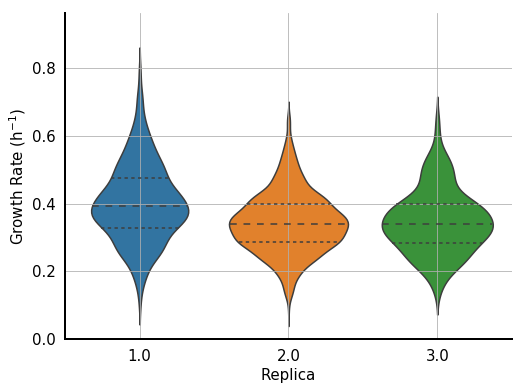

In [720]:
data1=pd.read_csv("./DSMdata.csv")
fig, ax = plt.subplots(1,1, figsize=(8,6))
mean=[]
errormean=[]
color=["#019D30","#01619D","#FC0000"]
i=0
for r in [1,2,3]:
    df=data1[data1.Replica==r]
    tt=df.gr
    #sns.distplot(df.gr,bins=20,label="Replica "+str(r),color=color[i])
    mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
    print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
    mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
    print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))
    print(len(tt))
    #plt.plot([np.mean(tt),np.mean(tt)],[0,5],c=color[i])
    i+=1
tt=data1.gr
    #sns.distplot(df.gr,bins=30,label="Replica "+str(r))
mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))

sns.violinplot(x=data1.Replica, y=data1.gr,inner="quart")


ax.set_ylim([0,1.2*np.max(data1.gr)])
ax.grid()
plt.xlabel("Replica",size=15)
#plt.grid()
#plt.legend(loc=4,fontsize=15)
#plt.yscale('log')
plt.ylabel("Growth Rate (h$^{-1}$)",size=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
#plt.legend()
#plt.title(Growth)
#ax.set_title('Casos Reportados por localidad en Bogota (10 de Mayo de 2020)',fontsize=18)
plt.savefig('./grdist.eps',bbox_inches='tight',dpi=600)
plt.savefig('./grdist.png',bbox_inches='tight',dpi=600)
#plt.errorbar([1,2,3],mean,yerr=errormean, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
#plt.title("Growth Rate")
#plt.ylim([0,1.5*np.max(mean)])
#plt.legend()
#plt.grid()

mean=18.715+/-0.278
CV2=0.053+/-0.005
918
mean=16.577+/-0.14
CV2=0.039+/-0.002
2098
mean=18.409+/-0.444
CV2=0.042+/-0.008
278
mean=17.327+/-0.128
CV2=0.047+/-0.002


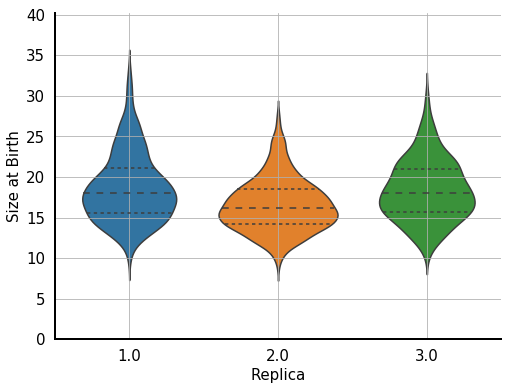

In [721]:
data1=pd.read_csv("./DSMdata.csv")
fig, ax = plt.subplots(1,1, figsize=(8,6))
mean=[]
errormean=[]
color=["#019D30","#01619D","#FC0000"]
i=0
for r in [1,2,3]:
    df=data1[data1.Replica==r]
    tt=df.Sb
    #sns.distplot(df.gr,bins=20,label="Replica "+str(r),color=color[i])
    mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
    print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
    mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
    print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))
    print(len(tt))
    #plt.plot([np.mean(tt),np.mean(tt)],[0,5],c=color[i])
    i+=1
tt=data1.Sb
    #sns.distplot(df.gr,bins=30,label="Replica "+str(r))
mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))

sns.violinplot(x=data1.Replica, y=data1.Sb,inner="quart")


ax.set_ylim([0,1.2*np.max(data1.Sb)])
ax.grid()
plt.xlabel("Replica",size=15)
#plt.grid()
#plt.legend(loc=4,fontsize=15)
#plt.yscale('log')
plt.ylabel("Size at Birth",size=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
#plt.legend()

#ax.set_title('Casos Reportados por localidad en Bogota (10 de Mayo de 2020)',fontsize=18)
plt.savefig('./Sbdist.eps',bbox_inches='tight',dpi=600)
plt.savefig('./Sbdist.png',bbox_inches='tight',dpi=600)
#plt.errorbar([1,2,3],mean,yerr=errormean, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
#plt.title("Growth Rate")
#plt.ylim([0,1.5*np.max(mean)])
#plt.legend()
#plt.grid()

mean=38.265+/-0.472
CV2=0.036+/-0.003
918
mean=34.136+/-0.227
CV2=0.024+/-0.001
2098
mean=37.145+/-0.72
CV2=0.027+/-0.005
278
mean=35.541+/-0.214
CV2=0.031+/-0.002


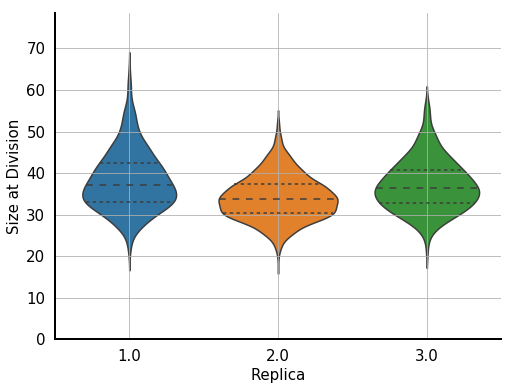

In [722]:
data1=pd.read_csv("./DSMdata.csv")
fig, ax = plt.subplots(1,1, figsize=(8,6))
mean=[]
errormean=[]
color=["#019D30","#01619D","#FC0000"]
i=0
for r in [1,2,3]:
    df=data1[data1.Replica==r]
    tt=df.Sd
    #sns.distplot(df.gr,bins=20,label="Replica "+str(r),color=color[i])
    mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
    print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
    mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
    print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))
    print(len(tt))
    #plt.plot([np.mean(tt),np.mean(tt)],[0,5],c=color[i])
    i+=1
tt=data1.Sd
    #sns.distplot(df.gr,bins=30,label="Replica "+str(r))
mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))

sns.violinplot(x=data1.Replica, y=data1.Sd,inner="quart")


ax.set_ylim([0,1.2*np.max(data1.Sd)])
ax.grid()
plt.xlabel("Replica",size=15)
#plt.grid()
#plt.legend(loc=4,fontsize=15)
#plt.yscale('log')
plt.ylabel("Size at Division",size=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
#plt.legend()

#ax.set_title('Casos Reportados por localidad en Bogota (10 de Mayo de 2020)',fontsize=18)
plt.savefig('./Sddist.eps',bbox_inches='tight',dpi=600)
plt.savefig('./Sddist.png',bbox_inches='tight',dpi=600)
#plt.errorbar([1,2,3],mean,yerr=errormean, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
#plt.title("Growth Rate")
#plt.ylim([0,1.5*np.max(mean)])
#plt.legend()
#plt.grid()

mean=19.551+/-0.431
CV2=0.116+/-0.011
918
mean=17.559+/-0.211
CV2=0.079+/-0.005
2098
mean=18.736+/-0.681
CV2=0.096+/-0.017
278
mean=18.213+/-0.191
CV2=0.095+/-0.005


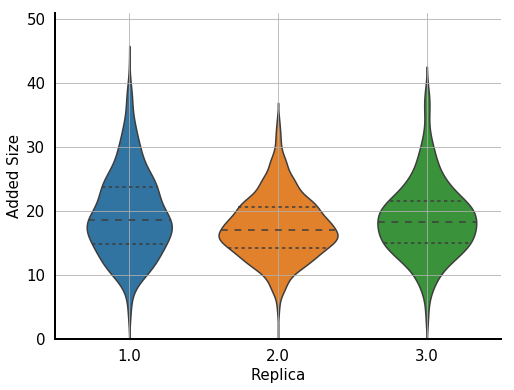

In [723]:
data1=pd.read_csv("./DSMdata.csv")
fig, ax = plt.subplots(1,1, figsize=(8,6))
mean=[]
errormean=[]
color=["#019D30","#01619D","#FC0000"]
i=0
for r in [1,2,3]:
    df=data1[data1.Replica==r]
    tt=df.Added
    #sns.distplot(df.gr,bins=20,label="Replica "+str(r),color=color[i])
    mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
    print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
    mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
    print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))
    print(len(tt))
    #plt.plot([np.mean(tt),np.mean(tt)],[0,5],c=color[i])
    i+=1
tt=data1.Added
    #sns.distplot(df.gr,bins=30,label="Replica "+str(r))
mean_cntr, var_cntr, std_cntr = bayesest(tt,alpha=0.95)
print("mean="+str(np.round(mean_cntr[0],3))+"+/-"+str(np.round(mean_cntr[1][1]-mean_cntr[0],3)))
mean_cntr, var_cntr, std_cntr = bayesest(tt/np.mean(tt),alpha=0.95)
print("CV2="+str(np.round(var_cntr[0],3))+"+/-"+str(np.round(var_cntr[1][1]-var_cntr[0],3)))

sns.violinplot(x=data1.Replica, y=data1.Added,inner="quart")


ax.set_ylim([0,1.2*np.max(data1.Added)])
ax.grid()
plt.xlabel("Replica",size=15)
#plt.grid()
#plt.legend(loc=4,fontsize=15)
#plt.yscale('log')
plt.ylabel("Added Size",size=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
#plt.legend()

#ax.set_title('Casos Reportados por localidad en Bogota (10 de Mayo de 2020)',fontsize=18)
plt.savefig('./Addeddist.eps',bbox_inches='tight',dpi=600)
plt.savefig('./Addeddist.png',bbox_inches='tight',dpi=600)
#plt.errorbar([1,2,3],mean,yerr=errormean, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
#plt.title("Growth Rate")
#plt.ylim([0,1.5*np.max(mean)])
#plt.legend()
#plt.grid()

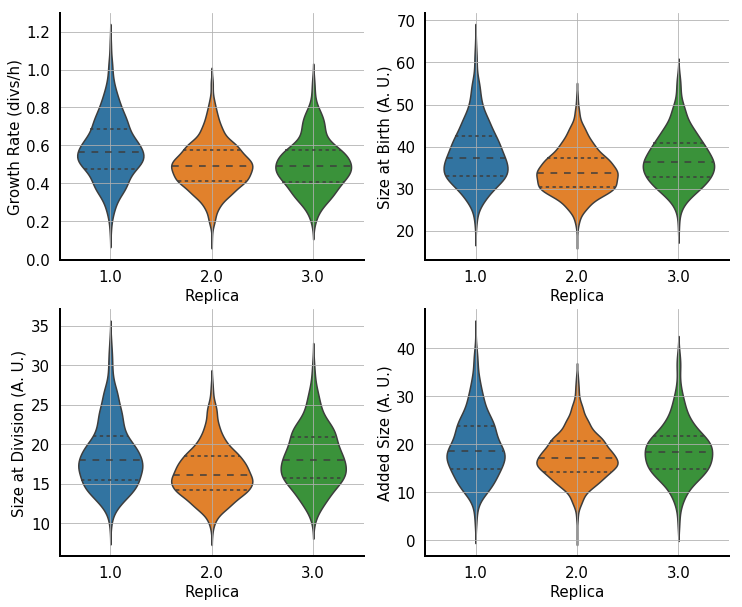

In [724]:
data1=pd.read_csv("./DSMdata.csv")
fig, ax = plt.subplots(2,2, figsize=(12,10))
mean=[]
errormean=[]
color=["#019D30","#01619D","#FC0000"]

sns.violinplot(x=data1.Replica, y=data1.gr/np.log(2),inner="quart",ax=ax[0,0])
sns.violinplot(x=data1.Replica, y=data1.Sb,inner="quart",ax=ax[1,0])
sns.violinplot(x=data1.Replica, y=data1.Sd,inner="quart",ax=ax[0,1])
sns.violinplot(x=data1.Replica, y=data1.Added,inner="quart",ax=ax[1,1])

#ax.set_ylim([0,1.2*np.max(data1.Added)])
i=0
yl=["Growth Rate (divs/h)","Size at Birth (A. U.)","Size at Division (A. U.)","Added Size (A. U.)"]
for l in [0,1]:
    for m in [0,1]:
        ax[l,m].grid()
        ax[l,m].set_xlabel("Replica",size=15)
        ax[l,m].set_ylabel(yl[2*l+m],size=15)
        #ax[l,m].set_ylabel(size=15)
        ax[l,m].tick_params(axis='x', labelsize=15)
        ax[l,m].tick_params(axis='y', labelsize=15)
        for axis in ['bottom','left']:
            ax[l,m].spines[axis].set_linewidth(2)
            ax[l,m].tick_params(axis='both', width=2,length=6)
        for axis in ['top','right']:
            ax[l,m].spines[axis].set_linewidth(0)
            ax[l,m].tick_params(axis='both', width=0,length=6)
#plt.legend()

#ax.set_title('Casos Reportados por localidad en Bogota (10 de Mayo de 2020)',fontsize=18)
plt.savefig('./Panelfig.eps',bbox_inches='tight',dpi=600)
plt.savefig('./panelfig.png',bbox_inches='tight',dpi=600)
#plt.errorbar([1,2,3],mean,yerr=errormean, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
#plt.title("Growth Rate")
#plt.ylim([0,1.5*np.max(mean)])
#plt.legend()

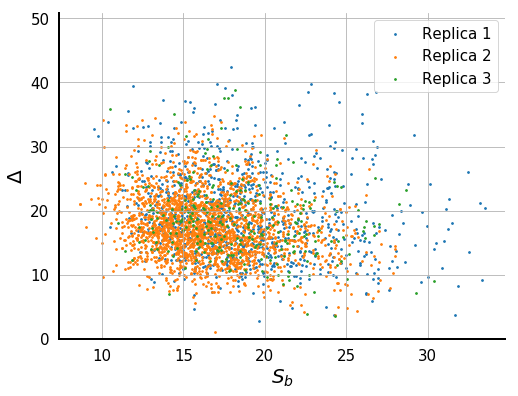

In [725]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
for r in [1,2,3]:
    df=data1[data1.Replica==r]
    plt.scatter(df.Sb,df.Sd-df.Sb,s=3,label="Replica "+str(r))
plt.xlabel("$S_b$",fontsize=15)
plt.ylabel("$\Delta$",fontsize=20)
plt.legend(fontsize=15)
ax.set_ylim([0,1.2*np.max(data1.Added)])
ax.grid()
plt.xlabel("$S_b$",size=20)
#plt.grid()
#plt.legend(loc=4,fontsize=15)
#plt.yscale('log')
#plt.ylabel("Added Size",size=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
#plt.legend()

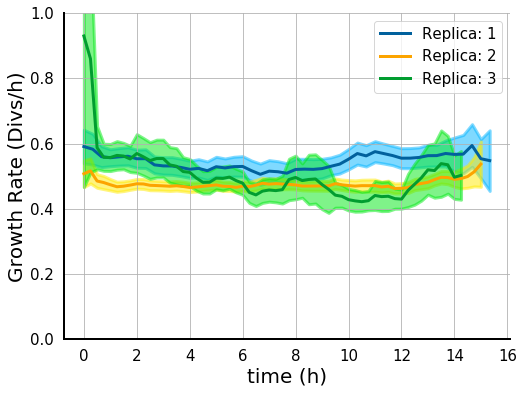

In [706]:
%matplotlib inline
colorin=[]
colorfill=["#00B4FF","#FFEB00","#00E914"]
color=["#01619D","#FCA400","#019D30"]

data=pd.read_csv("./CRMdata.csv")
fig, ax = plt.subplots(1,1, figsize=(8,6))
data=data[data.score>0.8]
i=0
for rep in [1,2,3]:
    df=data[data.Replica==rep]
    tarray=np.sort(df.time.unique())
    meangr=[]
    errorgr=[]
    meancv2gr=[]
    errorcv2gr=[]
    for t in tarray:
        dft=df[df.time==t]
        if (len(df)>1):
#        timecorrect.append(t)
            mean_cntr, var_cntr, std_cntr = bayesest(dft.gr,alpha=0.95)
            meangr.append(mean_cntr[0])
            errorgr.append(mean_cntr[1][1]-mean_cntr[0])
            meancv2gr.append(var_cntr[0]/mean_cntr[0]**2)
            errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
            errorcv2gr.append(errv)
            #errorcv2gr.append((std_cntr[1][1]-std_cntr[0])/mean_cntr[0]+(mean_cntr[1][1]-mean_cntr[0])*std_cntr[0]/(mean_cntr[0])**2)
    
    plt.fill_between(tarray, (np.array(meangr)+np.array(errorgr))/np.log(2), (np.array(meangr)-np.array(errorgr))/np.log(2),alpha=0.5,
                     edgecolor=colorfill[i], facecolor=colorfill[i],linewidth=3)
    plt.plot(tarray,np.array(meangr)/np.log(2),lw=3,label="Replica: "+str(rep),c=color[i])
    
    i+=1
plt.ylim([0,1])



#plt.ylim([0,1.2*np.max(data1.Added)])
plt.grid()
plt.xlabel("time (h)",size=20)
#plt.grid()
#plt.legend(loc=4,fontsize=15)
#plt.yscale('log')
plt.ylabel("Growth Rate (Divs/h)",size=20)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(axis='both', width=2,length=6)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
    ax.tick_params(axis='both', width=0,length=6)
#plt.legend()
plt.legend(fontsize=15)
#ax.set_title('Casos Reportados por localidad en Bogota (10 de Mayo de 2020)',fontsize=18)
plt.savefig('./grdyn.eps',bbox_inches='tight',dpi=600)
plt.savefig('./grdyn.png',bbox_inches='tight',dpi=600)

In [730]:
s0h=1.
steps=10
def kd(s):
    return np.log(2)*steps*1/(1+(s0h/s)**2.5)
def du(u,sb,t):
    v=np.zeros_like(u)
    s=sb*np.exp(mu*t)
    k=kd(s)
    for l in range(len(u)):
        if l==0:
            v[0]=(-k*s*u[0])*dt
        elif l==len(u)-1:
            v[len(u)-1]=(k*s*u[len(u)-2])*dt
        elif l==len(u)-2:
            v[len(u)-2]=(-k*s*u[len(u)-2]+k*s*u[len(u)-3])*dt
        else:
            v[l]=(-k*s*u[l]+k*s*u[l-1])*dt
    return v

tmax=10
dt=0.001
mu=np.log(2)


k=np.log(2)*steps
gammap=0*np.log(2)

sizedivarr01a=[]
CV2arr01a=[]

u=np.zeros(steps+1)
sbarray2=np.arange(0.5,3,0.01)
for sb in sbarray2:
    t=0
    count=10
    plim=[]
    tarrayfsp=[]
    u[0]=1
    while t<tmax:
        u+=du(u,sb,t)
        t+=dt
        count+=1
        if count>9:
            plim.append(u[-1])
            tarrayfsp.append(t)
            count=0
    tt=np.array(tarrayfsp)
    h=tt[1]-tt[0]
    rhot=np.diff(plim)/h
    trho=0.5*(tt[1:] + tt[:-1])
    sarray=sb*np.exp(mu*tt)
    ds=np.diff(sarray)
    ss=0.5*(sarray[1:] + sarray[:-1])
    rhos=rhot=np.diff(plim)/ds
    mn=np.trapz(rhos*ss,x=ss)
    var=np.trapz(rhos*(ss)**2,x=ss)
    CV2=(var-mn**2)/(mn-sb)**2
    sizedivarr01a.append(mn)
    CV2arr01a.append(CV2)

In [698]:
def du(u,sb,t):
    v=np.zeros_like(u)
    s=sb*np.exp(mu*t)
    for l in range(len(u)):
        if l==0:
            v[0]=(-k*s*u[0]+gammap*u[1])*dt
        elif l==len(u)-1:
            v[len(u)-1]=(k*s*u[len(u)-2])*dt
        elif l==len(u)-2:
            v[len(u)-2]=(-k*s*u[len(u)-2]+k*s*u[len(u)-3]-gammap*(len(u)-2)*u[len(u)-2])*dt
        else:
            v[l]=(-k*s*u[l]+k*s*u[l-1]-gammap*l*u[l]+gammap*(l+1)*u[l+1])*dt
    return v
tmax=10
dt=0.001
mu=np.log(2)
steps=20
k=np.log(2)*steps
gammap=1.7*np.log(2)

sizedivarr05=[]
CV2arr05=[]

u=np.zeros(steps+1)
sbarray=np.arange(0.1,6,0.1)
for sb in sbarray:
    t=0
    count=10
    plim=[]
    tarrayfsp=[]
    u[0]=1
    while t<tmax:
        u+=du(u,sb,t)
        t+=dt
        count+=1
        if count>9:
            plim.append(u[-1])
            tarrayfsp.append(t)
            count=0
    tt=np.array(tarrayfsp)
    h=tt[1]-tt[0]
    rhot=np.diff(plim)/h
    trho=0.5*(tt[1:] + tt[:-1])
    sarray=sb*np.exp(mu*tt)
    ds=np.diff(sarray)
    ss=0.5*(sarray[1:] + sarray[:-1])
    rhos=rhot=np.diff(plim)/ds
    mn=np.trapz(rhos*ss,x=ss)
    var=np.trapz(rhos*(ss)**2,x=ss)
    CV2=(var-mn**2)/(mn-sb)**2
    sizedivarr05.append(mn)
    CV2arr05.append(CV2)

In [699]:
data2=pd.read_csv("./DSMdata.csv")
normdata=[]
for rep in [1,2,3]:
    df=data[data.Replica==rep]
    dsb=df.Sb/np.mean(df.Sb)
    dad=df.Added/np.mean(df.Added)
    for i in range(len(dad)):
        normdata.append([dsb.tolist()[i],dad.tolist()[i]])
data2=pd.DataFrame(normdata,columns=["Sb","Added"])

(0.04, 0.12)

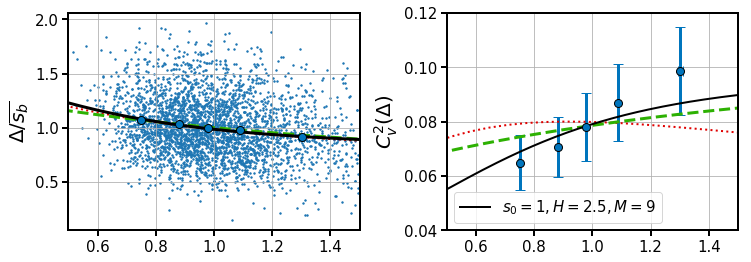

In [731]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

#data2=data2[data2.Replica!=1]
ax[0].scatter(data2.Sb,data2.Added,s=2)

quantnumber=5
pvadd2=data2
CV2d=[]
delt=[]
sb=[]
    
errcv2d=[]
errdelt=[]
errsb=[]
for i in range(quantnumber):
    lperv0=np.percentile(pvadd2.Sb,i*100/quantnumber)
    hperv0=np.percentile(pvadd2.Sb,(i+1)*100/quantnumber)
    quanta1=pvadd2[pvadd2.Sb>lperv0]
    quanta2=quanta1[quanta1.Sb<hperv0]     
    mean_cntr, var_cntr, std_cntr = bayesest(quanta2.Added,alpha=0.95)
    meanv0_cntr, varv0_cntr, stdv0_cntr = bayesest(quanta2.Sb,alpha=0.95)
    CV2d.append(var_cntr[0]/mean_cntr[0]**2)
    delt.append(mean_cntr[0])
    sb.append(meanv0_cntr[0])
    errv=(var_cntr[1][1]-var_cntr[0])/mean_cntr[0]**2+2*(mean_cntr[1][1]-mean_cntr[0])*var_cntr[0]/mean_cntr[0]**3
    errcv2d.append(errv)
    errdelt.append(mean_cntr[1][1]-mean_cntr[0])
    errsb.append(meanv0_cntr[1][1]-meanv0_cntr[0])
ax[0].errorbar(np.array(sb),np.array(delt),xerr=errsb,yerr=errdelt, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].errorbar(np.array(sb),CV2d,xerr=errsb,yerr=errcv2d, fmt='o',mec='k',capsize=5,markersize='8',elinewidth=3,c='#0075BD')
ax[1].set_ylim([0,0.3])


lamb=1.5
nsteps=9
s0=(1/nsteps)**(1/lamb)
xx = np.arange(0,3,0.01)
def rel(x):
    return lamb**(1/lamb)*np.exp((x)**lamb/lamb)*scipy.special.gamma(1+1/lamb)*scipy.special.gammaincc(1+1/lamb,(x)**lamb/lamb)-2*x
s0r=scipy.optimize.bisect(rel,0,100)
avg=s0*np.exp((xx/s0)**lamb/lamb)*lamb**(1/lamb)*scipy.special.gamma(1+1/lamb)*scipy.special.gammaincc(1+1/lamb, (xx/s0)**lamb/lamb)
avg2=s0*s0*lamb**(2/lamb)*np.exp((xx/s0)**lamb/lamb)*scipy.special.gamma(1+2/lamb)*scipy.special.gammaincc(1+2/lamb, (xx/s0)**lamb/lamb)

ax[0].plot(sbarray/1.55,(np.array(sizedivarr05)-np.array(sbarray))/1.55,lw=2,label='$\gamma_p=\mu$',c='#E00000',linestyle='dotted')
ax[1].plot(sbarray/1.55,np.array(CV2arr05),lw=2,c='#E00000',linestyle='dotted')
ax[0].plot(xx/(s0*s0r),((avg-xx)/s0)/(s0r),lw=3,label='$\lambda=%.1f$' %lamb,c='#2DB102',linestyle='dashed')    
ax[1].plot(xx/(s0*s0r),(avg2-avg**2)/(nsteps*(avg-xx)**2),lw=3,c='#2DB102',linestyle='dashed')
ax[1].plot(sbarray2/1.25,np.array(CV2arr01a),lw=2,c='k',label='$s_0=1,H=2.5,M=9$')
ax[0].plot(sbarray2/1.25,(np.array(sizedivarr01a)-np.array(sbarray2))/1.25,lw=3,c='k')
ax[1].legend(fontsize=15)

ax[0].set_xlim(0.5,1.5)
ax[1].set_xlim(0.5,1.5)
for i in [0,1]:
    ax[i].grid()
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
        ax[i].tick_params(axis='both', width=2,length=6)
        #ax[i].legend(fontsize=15)
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
ax[0].set_ylabel(r'$\Delta/\overline{s_b}$',size=20)
ax[1].set_ylabel(r'$C^2_v(\Delta)$',size=20)
ax[1].set_ylim(0.04,0.12)